# Import Modules

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np
import json
import glob
import operator

from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Import Dataset

In [3]:
dataset = pd.read_excel("FlightDataset.xlsx")
dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Preprocessing

In [4]:
dataset.isnull().sum()
dataset.dropna(inplace = True)

In [5]:
dataset["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [6]:
dataset = dataset[dataset["Airline"] != 'Trujet']
dataset = dataset[dataset["Airline"] != 'Vistara Premium economy']
dataset = dataset[dataset["Airline"] != 'Jet Airways Business']
dataset = dataset[dataset["Airline"] != 'Multiple carriers Premium economy']
dataset = dataset[dataset["Airline"] != 'GoAir']

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10465 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10465 non-null  object
 1   Date_of_Journey  10465 non-null  object
 2   Source           10465 non-null  object
 3   Destination      10465 non-null  object
 4   Route            10465 non-null  object
 5   Dep_Time         10465 non-null  object
 6   Arrival_Time     10465 non-null  object
 7   Duration         10465 non-null  object
 8   Total_Stops      10465 non-null  object
 9   Additional_Info  10465 non-null  object
 10  Price            10465 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 981.1+ KB


In [8]:
dataset["Journey-Date"] = pd.to_datetime(dataset.Date_of_Journey, format="%d/%m/%Y").dt.day
dataset["Journey-Month"] = pd.to_datetime(dataset.Date_of_Journey, format = "%d/%m/%Y").dt.month

In [9]:
dataset["Departure-Hour"] = pd.to_datetime(dataset.Dep_Time).dt.hour
dataset["Departure-Minutes"] = pd.to_datetime(dataset.Dep_Time).dt.minute

In [10]:
dataset["Arrival-Hour"] = pd.to_datetime(dataset.Arrival_Time).dt.hour
dataset["Arrival-Minutes"] = pd.to_datetime(dataset.Arrival_Time).dt.minute

In [11]:
journey_length = list(dataset["Duration"])

for i in range(len(journey_length)):
    if len(journey_length[i].split()) != 2:
        if "h" in journey_length[i]: journey_length[i] = journey_length[i].strip() + " 0m"
        else: journey_length[i] = "0h " + journey_length[i]

dh, dm = [], []
for i in range(len(journey_length)):
    dh.append(int(journey_length[i].split(sep = "h")[0]))
    dm.append(int(journey_length[i].split(sep = "m")[0].split()[-1]))

dataset["Duration-Hour"], dataset["Duration-Minutes"] = dh, dm

In [12]:
#dataset = dataset.drop(["Additional_Info", "Arrival_Time", "Dep_Time", "Duration", "Date_of_Journey", "Route"], axis = 1)

In [13]:
dataset.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [14]:
dataset.tail()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey-Date,Journey-Month,Departure-Hour,Departure-Minutes,Arrival-Hour,Arrival-Minutes,Duration-Hour,Duration-Minutes
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,0,No info,4107,9,4,19,55,22,25,2,30
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,0,No info,4145,27,4,20,45,23,20,2,35
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,0,No info,7229,27,4,8,20,11,20,3,0
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,0,No info,12648,1,3,11,30,14,10,2,40
10682,Air India,9/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,10:55,19:15,8h 20m,2,No info,11753,9,5,10,55,19,15,8,20


# Exploratory Data Analysis

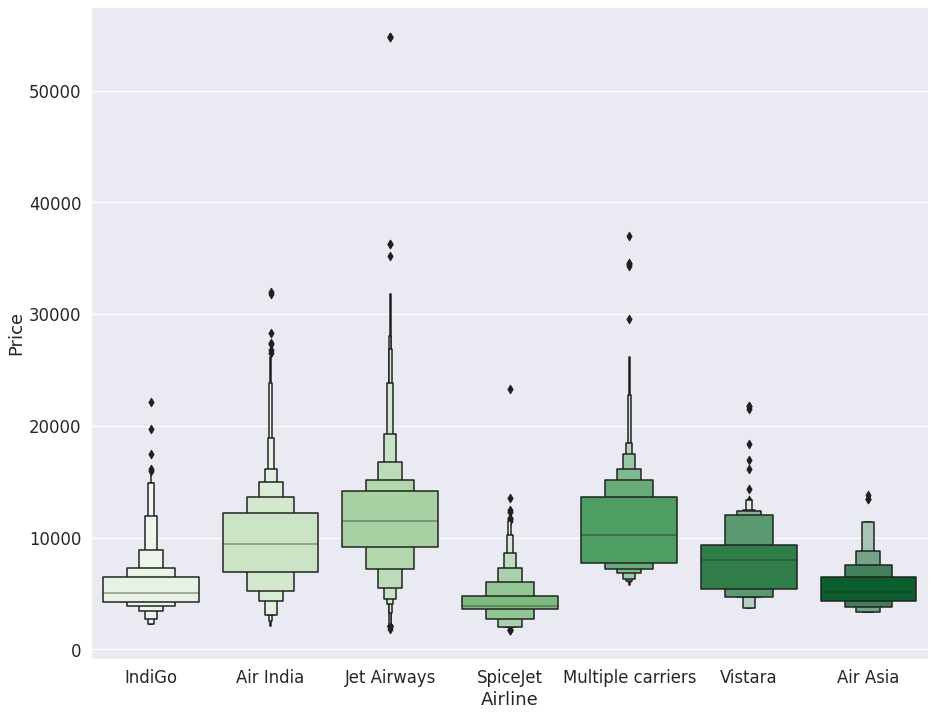

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as plt
from matplotlib import rcParams
import numpy as np
sns.set_style("darkgrid")

sns.set(font_scale = 1.5)
rcParams['figure.figsize'] = 15,12
sns.set_style("darkgrid")
colors = ["g", "o"]

ax = sns.boxenplot(x = 'Airline', y = 'Price', hue="Airline", data=dataset, dodge =False, palette="Greens")
ax.get_legend().set_visible(False)

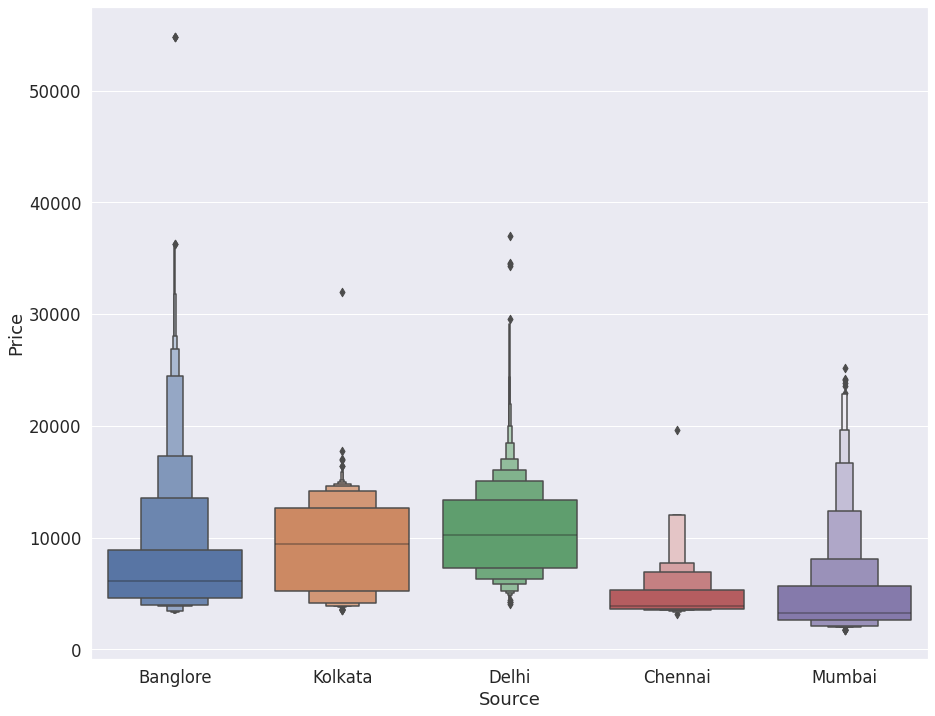

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as plt
from matplotlib import rcParams
import numpy as np
sns.set_style("darkgrid")

sns.set(font_scale = 1.5)
rcParams['figure.figsize'] = 15,12
sns.set_style("darkgrid")
colors = ["g", "o"]

ax = sns.boxenplot(x = 'Source', y = 'Price', hue="Source", data=dataset, dodge =False)
ax.get_legend().set_visible(False)

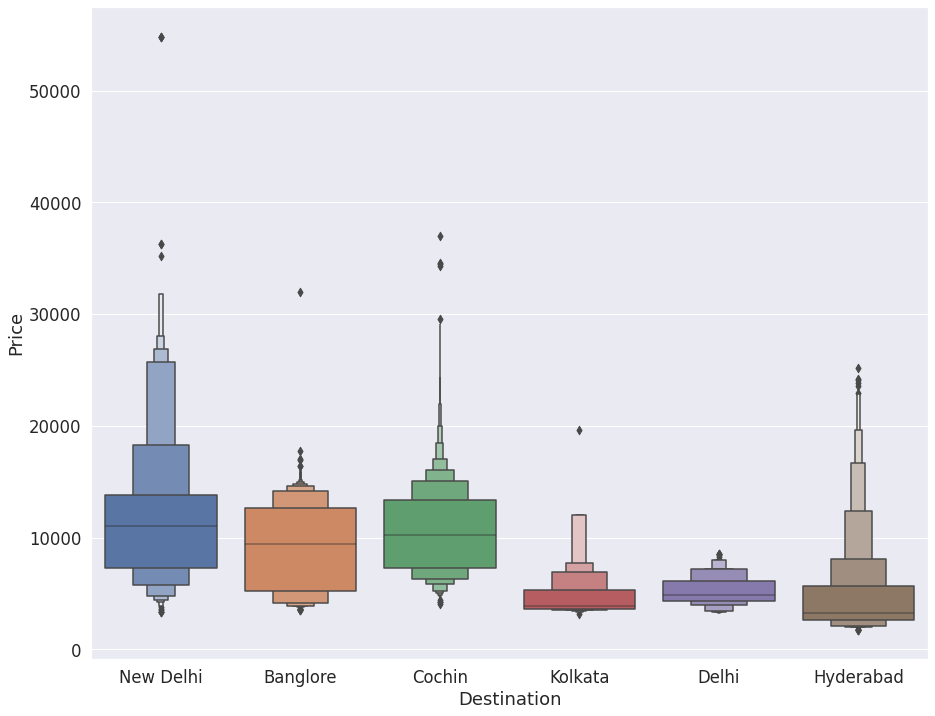

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as plt
from matplotlib import rcParams
import numpy as np
sns.set_style("darkgrid")

sns.set(font_scale = 1.5)
rcParams['figure.figsize'] = 15,12
sns.set_style("darkgrid")
colors = ["g", "o"]

ax = sns.boxenplot(x = 'Destination', y = 'Price', hue="Destination", data=dataset, dodge =False)
ax.get_legend().set_visible(False)

In [18]:
Airline = pd.get_dummies(dataset[["Airline"]], drop_first= True)
Source = pd.get_dummies(dataset[["Source"]], drop_first= True)
Destination = pd.get_dummies(dataset[["Destination"]], drop_first= True)

In [19]:
dataset = pd.concat([dataset, Airline, Source, Destination], axis = 1)

In [20]:
dataset = dataset.drop(["Additional_Info", "Arrival_Time", "Dep_Time", "Duration", "Date_of_Journey", "Route", "Airline", "Source", "Destination"], axis = 1)

In [21]:
labels = np.array(dataset['Price'])
features= dataset.drop('Price', axis = 1)

feature_list = list(features.columns)
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (7848, 24)
Training Labels Shape: (7848,)
Testing Features Shape: (2617, 24)
Testing Labels Shape: (2617,)


In [22]:
#Random Forest Classifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(train_features, train_labels)


# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('\n\nMean Absolute Error:', round(np.mean(errors), 2))


# Calculating Accuracy 
print("\n\nAccuracy Score:",accuracy_score(test_labels, predictions))


# Calculating Recall 
print("\n\nRecall Score:",recall_score(test_labels, predictions, average='macro'))


# Calculating F1 Score 
print("\n\nF1 Score:",f1_score(test_labels, predictions, average='macro'))



Mean Absolute Error: 1473.63


Accuracy Score: 0.35995414596866643


Recall Score: 0.1736086177838908


F1 Score: 0.15634446319360668


In [23]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 120, num = 12)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5]

In [24]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [25]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [26]:
rf_random.fit(train_features,train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=120; total time=   2.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=120; total time=   3.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=120; total time=   2.6s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=120; total time=   2.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=120; total time=   4.1s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=75; total time=   2.5s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=75; total time=   2.1s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=75; tota

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=1,
                   param_distributions={'max_depth': [5, 6, 7, 8, 9, 10],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 56, 62, 69, 75, 81,
                                                         88, 94, 100, 107, 113,
                                                         120]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [27]:
rf_random.best_params_

{'n_estimators': 81,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 10}

In [28]:
prediction = rf_random.predict(test_features)

# Evaluation Metrics

In [31]:
print("Accuracy Score:",accuracy_score(test_labels, predictions))

Accuracy Score: 0.35995414596866643
